In [2]:
import pandas as pd
import pickle

df = pd.read_csv('../data/data_nlp_A.csv', parse_dates=['last_publish_date', 'date_min'])

In [3]:
# Initialize PowerTransformer
file_path = "../streamlit_app/pages/power_transformer_ext_impr.pkl"
with open(file_path, "rb") as file:
    loaded_pt = pickle.load(file)

In [4]:
# transform target and add as new column

target_nt = 'external_impressions'
external_impressions_transformed = loaded_pt.transform(df[[target_nt]])
df['external_impressions_transformed'] = external_impressions_transformed


/Users/brt/.virtualenvs/d-drivers/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [5]:
columns_numerical = df.select_dtypes(include=['number']).columns.tolist()
columns_categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
columns_boolean = df.select_dtypes(include=['bool']).columns.tolist()

In [6]:
columns_vertex_adopted =[
    'urls_per_days',
    'media_type', # instead of 'Autmedia_type_videohors'
    'word_count',
    'video_player_types', # instead of encoded/transformed 'video_standard_and_widget' and 'video_widget'
    'classification_product',
    # 'video_widget', # commented out, see comment in line 'video_standard_and_widget' and 'video_widget'
    'meta_title_len',
    'author_list',  # instead of 'Authors'
    'google_trend_label',
    'classification_type',
    'meta_desc_len',
    'google_trend_score',
    'abstract_len',
    'h1_len'
    ]

target = 'external_impressions_transformed'

data = df[columns_vertex_adopted + [target]]

In [7]:
import pycaret.regression as pyreg

In [8]:

s = pyreg.setup(data, target=target, transformation=True, session_id=42
          # transform_target=True,
          #  transform_target_method='yeo-johnson', 
          ) #‘yeo-johnson’ in fact lol

,Description,Value
0,Session id,42
1,Target,external_impressions_transformed
2,Target type,Regression
3,Original data shape,"(6815, 14)"
4,Transformed data shape,"(6815, 40)"
5,Transformed train set shape,"(4770, 40)"
6,Transformed test set shape,"(2045, 40)"
7,Numeric features,7
8,Categorical features,6
9,Rows with missing values,14.6%


In [9]:
best = pyreg.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7248,0.8590,0.9260,0.6020,0.3466,2.4765,0.8060
gbr,Gradient Boosting Regressor,0.7294,0.8623,0.9279,0.6006,0.3445,2.4976,0.1840
rf,Random Forest Regressor,0.7373,0.8920,0.9437,0.5869,0.3521,2.5486,0.4110
et,Extra Trees Regressor,0.7452,0.9152,0.9562,0.5758,0.3592,2.5323,0.3090
xgboost,Extreme Gradient Boosting,0.7628,0.9661,0.9822,0.5521,0.3655,2.6028,0.1190
ada,AdaBoost Regressor,0.8355,1.0835,1.0405,0.4982,0.3750,3.0807,0.1670
ridge,Ridge Regression,0.8324,1.0950,1.0459,0.4936,0.3922,2.4800,0.0650
en,Elastic Net,0.9552,1.4628,1.2085,0.3240,0.3947,3.0459,0.0770
llar,Lasso Least Angle Regression,0.9952,1.5797,1.2559,0.2701,0.3978,3.1852,0.0550
lasso,Lasso Regression,0.9952,1.5797,1.2559,0.2701,0.3978,3.1852,0.2340


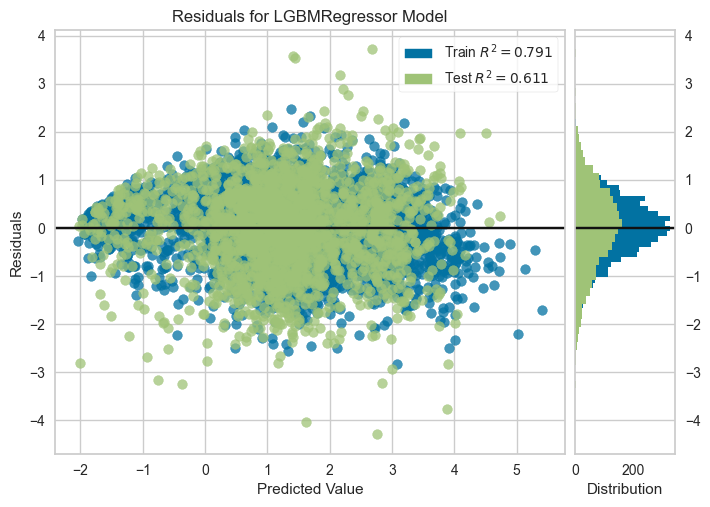

In [10]:
pyreg.plot_model(best, plot = 'residuals')

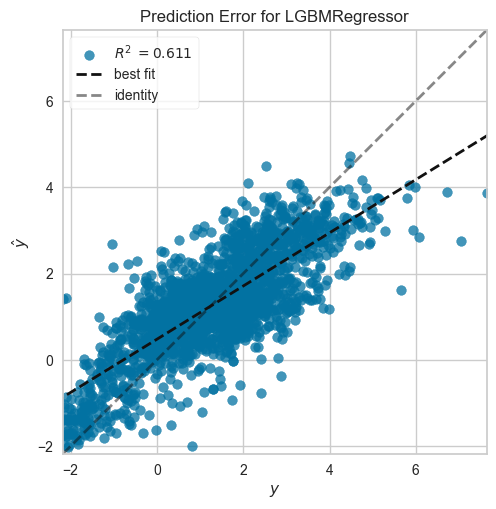

In [11]:
pyreg.plot_model(best, plot='error')

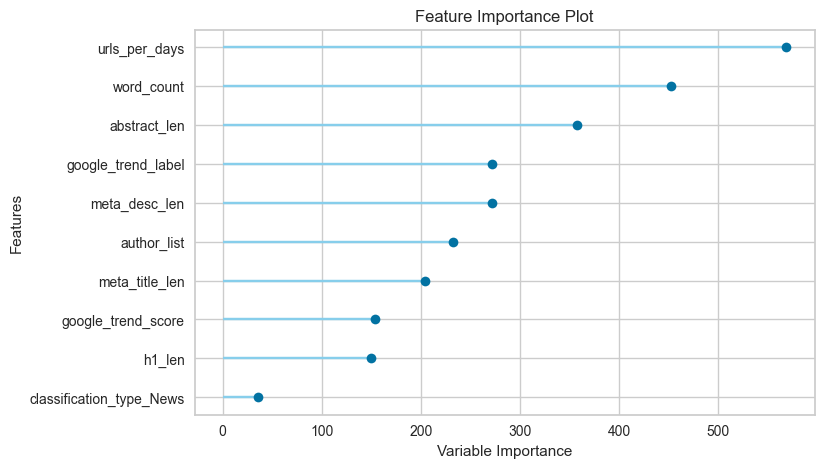

In [12]:
pyreg.plot_model(best, plot = 'feature')

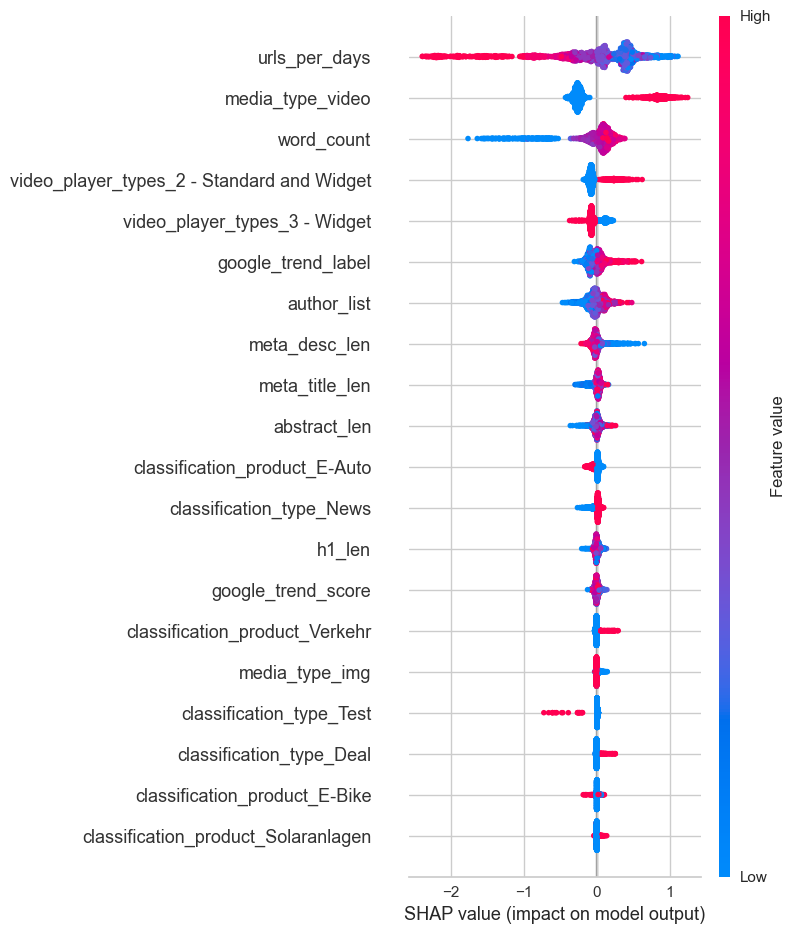

In [13]:
pyreg.interpret_model(best)

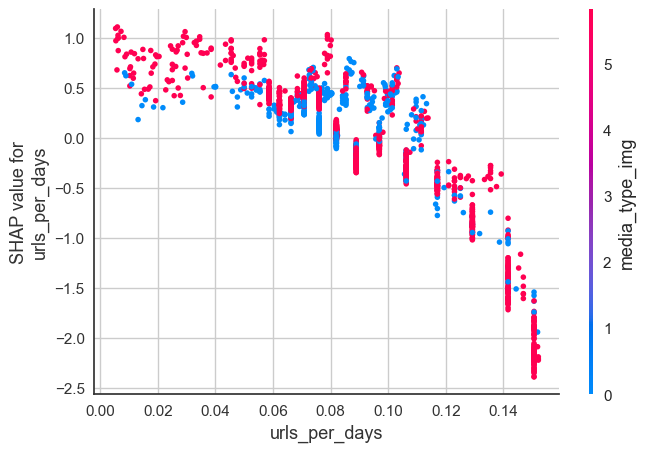

In [14]:
pyreg.interpret_model(best, plot = 'correlation')

In [15]:
pyreg.save_experiment('../models/bl_experiment_ext_imp_trans.pkl')

In [16]:
lightgbm = pyreg.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7353,0.8839,0.9402,0.5860,0.3568,1.7267
1,0.7105,0.8458,0.9197,0.6000,0.3429,2.4549
2,0.7141,0.8394,0.9162,0.5877,0.3511,3.3384
3,0.7451,0.9172,0.9577,0.5937,0.3608,1.8885
4,0.7642,0.9540,0.9767,0.6228,0.3481,2.1247
5,0.6844,0.7610,0.8724,0.6569,0.3190,1.7202
6,0.6910,0.7725,0.8789,0.6153,0.3336,1.4630
7,0.7746,0.9832,0.9916,0.5254,0.3763,4.8966
8,0.7146,0.8350,0.9138,0.5963,0.3274,3.5533


# X. Tune Hyperparameters

In [17]:
tuned_lightgbm = pyreg.tune_model(lightgbm, n_iter=50, optimize = 'R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7324,0.8884,0.9425,0.5839,0.3582,1.6662
1,0.6960,0.7970,0.8927,0.6231,0.3367,2.2702
2,0.7304,0.8593,0.9270,0.5779,0.3583,3.4595
3,0.7238,0.8634,0.9292,0.6175,0.3511,1.7086
4,0.7569,0.9311,0.9649,0.6318,0.3524,2.3968
5,0.6955,0.7490,0.8654,0.6623,0.3155,1.6326
6,0.6936,0.7838,0.8853,0.6097,0.3403,1.4547
7,0.7670,0.9818,0.9909,0.5261,0.3772,4.6875
8,0.7107,0.8179,0.9044,0.6045,0.3276,3.7469


Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [18]:
tuned_lightgbm

LGBMRegressor(bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8,
              learning_rate=0.05, min_child_samples=31, min_split_gain=0.3,
              n_estimators=130, n_jobs=-1, num_leaves=80, random_state=42,
              reg_alpha=2, reg_lambda=0.4)

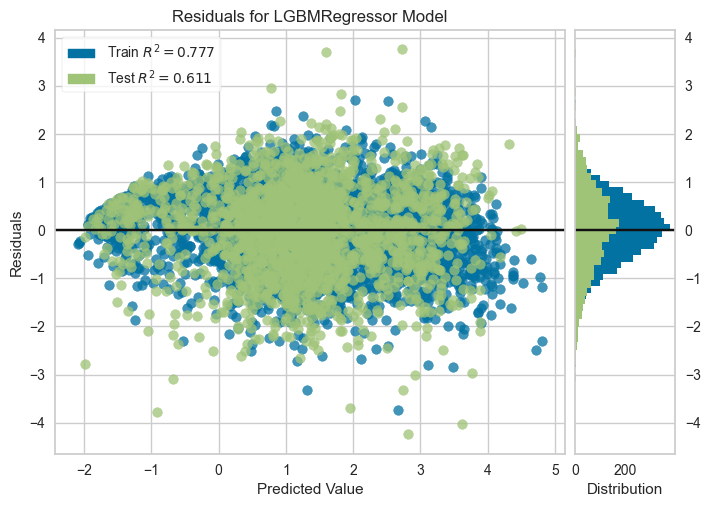

In [19]:
pyreg.plot_model(tuned_lightgbm, plot = 'residuals')

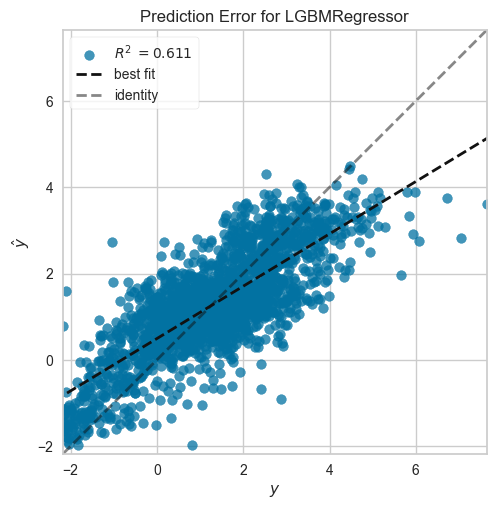

In [20]:
pyreg.plot_model(tuned_lightgbm, plot = 'error')

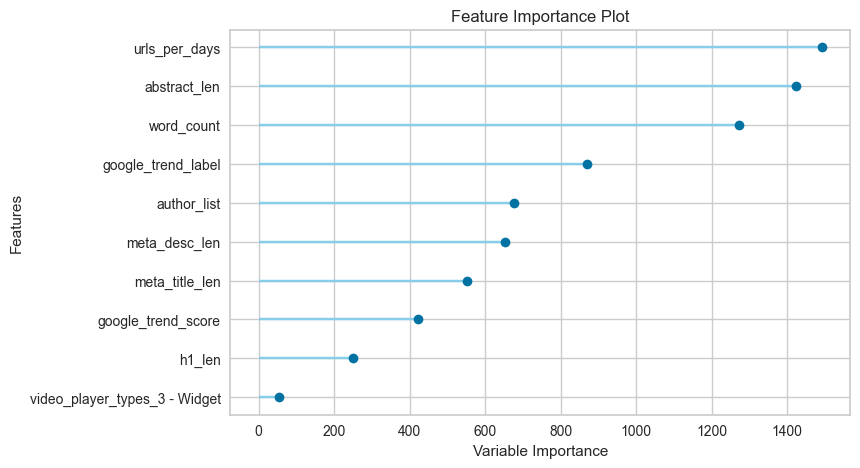

In [21]:
pyreg.plot_model(tuned_lightgbm, plot = 'feature')

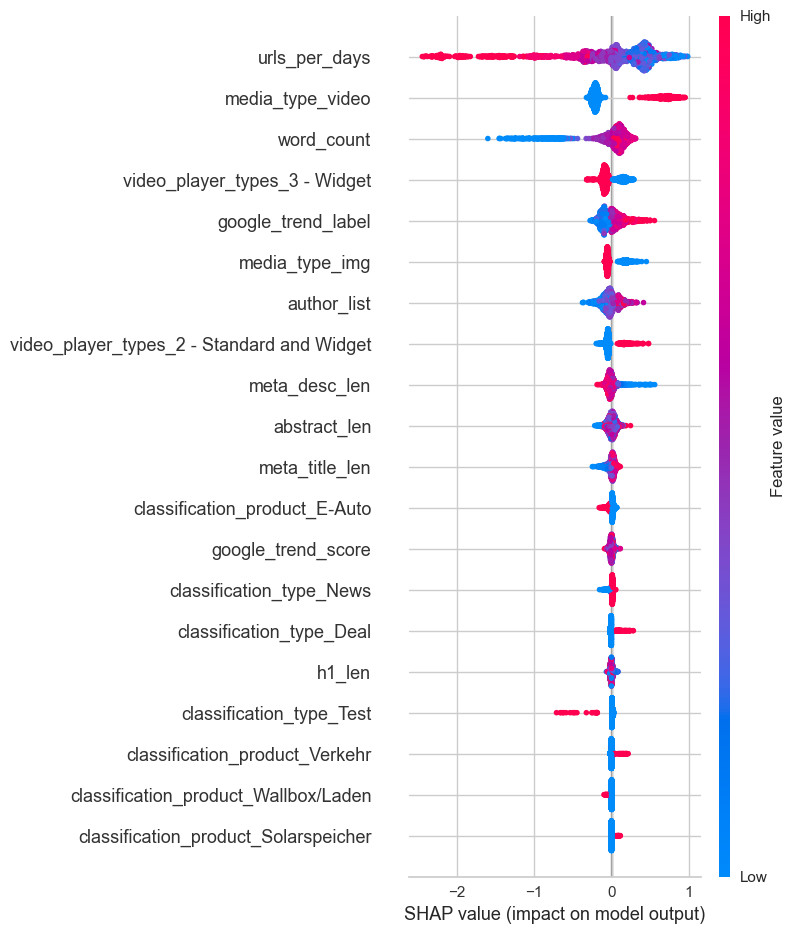

In [22]:
pyreg.interpret_model(tuned_lightgbm)

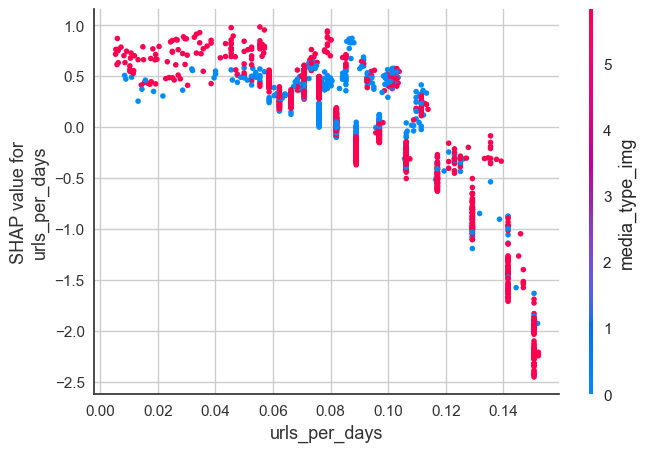

In [23]:
pyreg.interpret_model(tuned_lightgbm, plot = 'correlation')

In [24]:
pyreg.dashboard(tuned_lightgbm)

Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Calculating residuals...
Calculating absolute residuals...
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytre

# X. Save and Load model

In [25]:
pyreg.save_model(model=tuned_lightgbm, model_name='../models/lightgbm_tuned_ext_imp_pt')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['urls_per_days', 'word_count',
                                              'meta_title_len', 'meta_desc_len',
                                              'google_trend_score',
                                              'abstract_len', 'h1_len'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['media_type', 'video_player_types',
                                              'classification_product',
                                              'author_...
                                                               handle_missing='return_nan'))),
                 ('transformation',
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                 ('trained_model',
                  LGBMRegressor(bagging_fractio

In [26]:
model_loaded = pyreg.load_model('../models/lightgbm_tuned_ext_imp_pt')

Transformation Pipeline and Model Successfully Loaded


In [27]:
# display pipeline

from sklearn import set_config
set_config(display='diagram')
model_loaded[0]

TransformerWrapper(include=['urls_per_days', 'word_count', 'meta_title_len',
                            'meta_desc_len', 'google_trend_score',
                            'abstract_len', 'h1_len'],
                   transformer=SimpleImputer())

# 2. predict


In [28]:
instance_dict = {
    "word_count": 390,
    "classification_product": 'Solaranlagen',
    "classification_type": 'Kaufberatung',
    "urls_per_days": 0.1,
    "meta_title_len": 75,
    "meta_desc_len": 145,
    "h1_len": 66,
    "abstract_len": 250,
    "google_trend_label": 'elektroauto',
    "google_trend_score": 33,
    "video_player_types": '2 - Standard and Widget',
    "media_type": 'video',
    "author_list": 'Lisa Brack',
}


In [29]:
x = pd.DataFrame([instance_dict])

y_trans = model_loaded.predict(x)
y_trans # 3.24183743

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


array([3.24183743])

In [30]:
# back transform

y = loaded_pt.inverse_transform(y_trans.reshape(-1, 1))
y[0][0] # 1202124.2238394711

1202124.2238394711

In [31]:
# alternative prediction with original model instance

predict_new = pyreg.predict_model(tuned_lightgbm, data=x)
predicted_value = predict_new['prediction_label'][0]
display(predicted_value)
display(predict_new.head())

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


3.2418374349356913

,word_count,classification_product,classification_type,urls_per_days,meta_title_len,meta_desc_len,h1_len,abstract_len,google_trend_label,google_trend_score,video_player_types,media_type,author_list,prediction_label
0,390,Solaranlagen,Kaufberatung,0.1,75,145,66,250,elektroauto,33,2 - Standard and Widget,video,Lisa Brack,3.241837


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b